In [2]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession

sc = SparkContext("local", "week6")
spark = SparkSession(sc)

In [3]:
def create_setdata(ss):
    record = set()
    for i in ss:
        if i not in record:
            record.add(i)
        else:
            yield record
            record = set()
    if not record:
        yield record

In [4]:
def create_dataset(N):
    while True:
        s = np.random.default_rng().zipf(1.2, N*10*10)
        dataset = list(create_setdata(s[s<N]))
        if len(dataset) >= N:
            break
            
    ids = range(N)
    return [(i,s) for i, s in zip(ids, dataset[:N])]

In [20]:
testcaseN = [1000, 2000, 4000, 8000, 16000]
execute_time = []

import time
import numpy as np

for N in testcaseN:
    start = time.time()
    
    pr = sc.broadcast([1./float(N) for _ in range(N)])
    
    dataset = create_dataset(N)
    inputRDD = sc.parallelize(dataset).cache()

    for iterNo in range(50):
        itr = inputRDD.flatMap(lambda t:[(target, pr.value[t[0]]/len(t[1])) for target in t[1]])
        itr = inputRDD.map(lambda t: (t[0],0)).union(itr).reduceByKey(lambda x,y:x+y).mapValues(lambda v: 0.85*v + 1/N * (1-0.85)).cache()
        
        pr = sc.broadcast(itr.map(lambda t:t[1]).collect())
    
    end = time.time()
    execute_time.append(end-start)

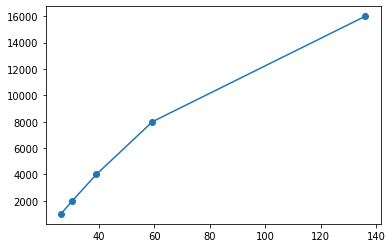

In [21]:
import matplotlib.pyplot as plt

plt.plot(execute_time, testcaseN, linestyle='-', marker='o')
plt.show()